# Avaliando o impacto de uma política pública: **Data Envelopment Analysis** (*DEA*)

----

## Leitura dos Dados

In [1]:
## Já instalando bibliotecas necessárias
from IPython.display import clear_output # limpa o output de uma célula
!pip uninstall scipy -y
!pip install scipy

clear_output()  # limpando o texto

In [2]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import linprog
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## Estilos dos gráficos
from matplotlib import style
style.use('ggplot')

In [4]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## Lendo os dados
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Avaliação de Impacto de Políticas - World Bank/Dados/"
# sCaminho = '/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoII/Códigos/'

sArquivo = "DadosEmpresasEnergia.xlsx"

## Lendo o DataFrame
df = pd.read_excel(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 18; Colunas: 5


In [6]:
## Vendo o df
df

,UTILITY,OPEX,NETWORK,MWH,CUSTOMERS
0,ELETROPAULO,1249143613,45213,39922710,5987783
1,CEMIG,1682334644,460219,37476802,6832546
2,CPFL -paulista,497290782,89879,25267579,3502793
3,COPEL,1018866491,224817,23525040,3628209
4,LIGHT,557206112,58074,22902552,3640182
5,CELESC,721455274,144896,18105811,2237127
6,COELBA,436436014,215001,14286757,4622046
7,ELEKTRO,414602018,107116,13398558,2123670
8,CPFL- Piratininga,195789961,22236,13013378,1367488
9,BANDEIRANTE,286832273,27496,12536237,1482518


In [7]:
## Descrevendo o DataFrame
# Usando o apply para suprimir notação científica e colocar duas casas decimais
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,OPEX,NETWORK,MWH,CUSTOMERS
count,18.00,18.00,18.00,18.00
mean,548593636.67,120900.06,16000161.61,2819017.11
std,402117103.33,104457.59,10065817.95,1652415.95
min,186357415.00,22236.00,7277929.00,1150518.00
25%,294165923.75,57238.50,8330900.00,1449183.50
50%,425519016.00,87438.00,12774807.50,2301342.50
75%,657905717.75,138779.00,21703366.75,3596855.00
max,1682334644.00,460219.00,39922710.00,6832546.00


## Data Envelopment Analysis - DEA

Na análise dos dados de eletricidade, o *input* é o OPEX, enquanto as variáveis de *output* são NETWORK, MWH e CUSTOMERS.

### Análise CRS - Constant Returns to Scale / Retornos Constantes de Escala


#### Arrumando os dados

In [8]:
## Número de linhas, de variáveis de input e de output
N = df.shape[0]  # número de DMUs (igual ao número de linhas)
s = 1  # número de variáveis de input
m = 3  # número de variáveis de output

In [9]:
## Selecionando os dados
dfInput = df.iloc[:, s]
dfOutput = df.iloc[:, s + 1:m + 2]

In [10]:
## Vendo os resultados
# Input
dfInput

0     1249143613
1     1682334644
2      497290782
3     1018866491
4      557206112
5      721455274
6      436436014
7      414602018
8      195789961
9      286832273
10     350651684
11     436532756
12     691472253
13     186357415
14     316166876
15     241433335
16     206122962
17     385990997
Name: OPEX, dtype: int64

In [11]:
# Output
dfOutput

,NETWORK,MWH,CUSTOMERS
0,45213,39922710,5987783
1,460219,37476802,6832546
2,89879,25267579,3502793
3,224817,23525040,3628209
4,58074,22902552,3640182
5,144896,18105811,2237127
6,215001,14286757,4622046
7,107116,13398558,2123670
8,22236,13013378,1367488
9,27496,12536237,1482518


In [12]:
## Matriz/DataFrame com os coeficientes tecnológicos (-Input)
dfTecno = pd.concat([-dfInput, dfOutput], axis=1)

# Passando pra numpy e vendo os valores
mTecno = dfTecno.values
dfTecno

,OPEX,NETWORK,MWH,CUSTOMERS
0,-1249143613,45213,39922710,5987783
1,-1682334644,460219,37476802,6832546
2,-497290782,89879,25267579,3502793
3,-1018866491,224817,23525040,3628209
4,-557206112,58074,22902552,3640182
5,-721455274,144896,18105811,2237127
6,-436436014,215001,14286757,4622046
7,-414602018,107116,13398558,2123670
8,-195789961,22236,13013378,1367488
9,-286832273,27496,12536237,1482518


#### Otimização passo a passo para a 1ª linha

##### Restrições

In [15]:
## Encontrando coeficientes da função objetivo
obj = np.hstack((
    [0] * s, # como s = 1, apenas um 0
    dfOutput.values[0, :]  # valores da 1ª linha de dfOutput
))

## O problema de DEA é de maximização, mas o scipy só aceita minimização. Para isso,
## pegaremos o oposto da função objetivo (maximizar uma função é a mesma coisa de minimizar -ela)
obj = -obj

# Vendo array resultante
obj

array([        0,    -45213, -39922710,  -5987783])

In [16]:
## Encontrando coeficientes das restrições (constraints)
# Juntando a última linha (1º valor de dfInput seguido de zeros)
vUltLinhaCon = np.hstack((
    dfInput.values[0],   # 1º valor da única coluna de dfInput
    [0] * m  # um 0 para cada output
))

# Matriz de constraints
con = np.vstack((
    mTecno,
    vUltLinhaCon
))

## Vendo matriz resultante
con

array([[-1249143613,       45213,    39922710,     5987783],
       [-1682334644,      460219,    37476802,     6832546],
       [ -497290782,       89879,    25267579,     3502793],
       [-1018866491,      224817,    23525040,     3628209],
       [ -557206112,       58074,    22902552,     3640182],
       [ -721455274,      144896,    18105811,     2237127],
       [ -436436014,      215001,    14286757,     4622046],
       [ -414602018,      107116,    13398558,     2123670],
       [ -195789961,       22236,    13013378,     1367488],
       [ -286832273,       27496,    12536237,     1482518],
       [ -350651684,      120428,    10001560,     2994259],
       [ -436532756,       51050,     9506961,     2365558],
       [ -691472253,      199494,     9344291,     2213198],
       [ -186357415,       84997,     7993103,     1226079],
       [ -316166876,      120300,     7929212,     2744830],
       [ -241433335,       56960,     7897969,     1185432],
       [ -206122962,    

In [17]:
## Pegando os coeficientes de desigualdade (ineq) (<=) ou igualdade (eq) (=), que ficam no lado esquerdo
# lhs: left hand side
lhs_ineq = con[:-1]
lhs_eq = con[-1]

In [13]:
## Lado direito das equações
# rhs: right hand side
rhs = [0] * (N + 1)
rhs[-1] = 1
rhs

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [14]:
## Separando entre restrições de desigualdade (ineq) (<=) ou igualdade (eq) (=)
rhs_ineq = rhs[:-1]
rhs_eq = rhs[-1]

##### Problema Primal

In [18]:
# Otimizando
opt = linprog(
    c=obj,  # função objetivo (vetor de tamanho 4)
    A_ub=lhs_ineq,  # coeficientes das restrições de desigualdade (matriz de tamanho N(18) x 4)
    b_ub=rhs_ineq,  # valor das restrições de desigualdade (vetor de tamanho N (18))
    A_eq=lhs_eq.reshape((1, 4)),  # coeficientes das restrições de igualdade (matriz de tamanho 1 x 4)
    b_eq=rhs_eq, # valor das restrições de igualdade (vetor de tamanho 1 -> número)
    method='revised simplex'
)
# Vendo resultado
opt

     con: array([0.])
     fun: -0.5826970466854737
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([4.17302953e-01, 7.30952773e-01, 4.56127814e-02, 4.66617757e-01,
       1.00136946e-01, 3.40479010e-01, 0.00000000e+00, 1.29866060e-01,
       1.38777878e-17, 6.92462528e-02, 4.98396477e-02, 1.57316716e-01,
       3.71052835e-01, 3.09761752e-02, 4.89920634e-02, 7.79544008e-02,
       5.33803204e-02, 1.83091654e-01])
  status: 0
 success: True
       x: array([8.00548463e-10, 0.00000000e+00, 6.07395880e-09, 5.68170475e-08])

In [19]:
## Pegando multiplicadores
vMultiplicadores = opt.x

## Pegando índices de eficiência (- porque fizemos -obj antes)
nEficiencia = -opt.fun

##### Problema Dual

Um problema dual é aquele em que as funções objetivo e as restrições trocam de lugar, invertendo-se os sinais dos coeficientes das restrições.

Matematicamente, a solução do problema dual fornece um limite inferior para a solução do problema primal de minimização.

Infelizmente, o solver do scipy não fornece isso, de forma que temos que remontar o problema.

In [20]:
## Para que possamos fazer o dual, temos que transformar as restrições de igualdade em duas de desigualdade
# Se A + B = C, logo (A + B ≤ C) e (A + B ≥ C), ou seja, -(A + B) ≤ -C
lhs_ineq_dual = np.vstack((
    lhs_ineq,
    lhs_eq,
    -lhs_eq
))

# Vendo matriz resultante
lhs_ineq_dual

array([[-1249143613,       45213,    39922710,     5987783],
       [-1682334644,      460219,    37476802,     6832546],
       [ -497290782,       89879,    25267579,     3502793],
       [-1018866491,      224817,    23525040,     3628209],
       [ -557206112,       58074,    22902552,     3640182],
       [ -721455274,      144896,    18105811,     2237127],
       [ -436436014,      215001,    14286757,     4622046],
       [ -414602018,      107116,    13398558,     2123670],
       [ -195789961,       22236,    13013378,     1367488],
       [ -286832273,       27496,    12536237,     1482518],
       [ -350651684,      120428,    10001560,     2994259],
       [ -436532756,       51050,     9506961,     2365558],
       [ -691472253,      199494,     9344291,     2213198],
       [ -186357415,       84997,     7993103,     1226079],
       [ -316166876,      120300,     7929212,     2744830],
       [ -241433335,       56960,     7897969,     1185432],
       [ -206122962,    

In [21]:
## Fazendo a mesma coisa para o lado direito
rhs_ineq_dual = np.hstack((
    rhs_ineq,
    rhs_eq,
    -rhs_eq
))

## Vendo vetor resultante
rhs_ineq_dual

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1, -1])

In [22]:
## Resolvendo o problema dual
opt_dual = linprog(
    c=rhs_ineq_dual,  # função objetivo (vetor de tamanho 20)
    A_ub=-lhs_ineq_dual.T,  # coeficientes das restrições de desigualdade (matriz de tamanho 4 x 20)
    b_ub=obj,  # valor das restrições de desigualdade (vetor de tamanho N (r))
    method='revised simplex'
)
opt_dual

# Sabemos que fizemos certo pelo valor da função (eficiência)

     con: array([], dtype=float64)
     fun: 0.5826970466854738
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([ 2.38418579e-07,  1.32478572e+05, -7.45058060e-09,  0.00000000e+00])
  status: 0
 success: True
       x: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.57440572, 0.        , 2.43720847, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.58269705, 0.        ])

In [23]:
# Guardando valores e mostrando-os
# Como criamos duas restrições a mais, retiramos os seus valores
vDuals = opt_dual.x[:-2]
vDuals

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.57440572, 0.        , 2.43720847, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

#### Loop sobre todas as empresas geradoras de energia elétrica

In [24]:
## Fazendo o loop sobre todos as outras linhas do DataFrame
# Criando variáveis para guardar os vetores da otimização
mPesos = vMultiplicadores
vEficiencia = nEficiencia
mLambda = vDuals

for nLinha in range(1, N):
  ## Encontrando coeficientes da função objetivo;
  # Como o scipy só aceita minimização, pegamos o negativo do valor
  obj = -np.hstack(([0] * s, dfOutput.values[nLinha, :]))

  ## Encontrando restrições (constraints)
  # Juntando a última linha (1º valor de dfInput seguido de zeros)
  vUltLinhaCon = np.hstack((dfInput.values[nLinha], [0] * m))

  # Matriz de constraints
  con = np.vstack((mTecno, vUltLinhaCon))

  ## Pegando os coeficientes de desigualdade e igualdade
  lhs_ineq = con[:-1]
  lhs_eq = con[-1]

  ### Problema Primal
  opt = linprog(
    c=obj,  # função objetivo (vetor de tamanho 4)
    A_ub=lhs_ineq,  # coeficientes das restrições de desigualdade (matriz de tamanho N(18) x 4)
    b_ub=rhs_ineq,  # valor das restrições de desigualdade (vetor de tamanho N (18))
    A_eq=lhs_eq.reshape((1, 4)),  # coeficientes das restrições de igualdade (matriz de tamanho 1 x 4)
    b_eq=rhs_eq, # valor das restrições de igualdade (vetor de tamanho 1 -> número)
    method='revised simplex'
  )

  ## Pegando multiplicadores
  mPesos = np.vstack((mPesos, opt.x))

  ## Pegando índices de eficiência (- porque fizemos -obj antes)
  vEficiencia = np.hstack((vEficiencia, -opt.fun))

  ### Problema Dual
  ## Transformando restrições de igualdade em desigualdade
  lhs_ineq_dual = np.vstack((lhs_ineq, lhs_eq, -lhs_eq))
  rhs_ineq_dual = np.hstack((rhs_ineq, rhs_eq, -rhs_eq))

  ## Otimizando
  opt_dual = linprog(
    c=rhs_ineq_dual,  # função objetivo (vetor de tamanho 20)
    A_ub=-lhs_ineq_dual.T,  # coeficientes das restrições de desigualdade (matriz de tamanho 4 x 20)
    b_ub=obj,  # valor das restrições de desigualdade (vetor de tamanho N (r))
    method='revised simplex'
  )

  ## Pegando valores duais
  mLambda = np.vstack((mLambda, opt_dual.x[:-2]))

#### Gráficos

##### Eficiência

In [25]:
## Pegando os outputs virtuais, que medem a eficiência
mVirtual = mPesos[:, s:s + m] * dfOutput.values
mVirtual.shape

(18, 3)

In [26]:
## Criando DataFrame, cujas colunas são as variáveis de output e os indexes as companhias geradoras
dfVirtual = pd.DataFrame(mVirtual, index=df['UTILITY'], columns=dfOutput.columns)
dfVirtual

,NETWORK,MWH,CUSTOMERS
UTILITY,,,
ELETROPAULO,0.000000,0.242489,0.340208
CEMIG,0.448181,0.131279,0.000000
CPFL -paulista,0.000000,0.385512,0.499914
COPEL,0.178778,0.263277,0.076531
LIGHT,0.000000,0.311855,0.463659
CELESC,0.186086,0.337848,0.000000
COELBA,0.000000,0.248369,0.751631
ELEKTRO,0.209327,0.368491,0.110082
CPFL- Piratininga,0.000000,1.000000,0.000000


In [27]:
## Pegando a soma de cada linha
np.sum(dfVirtual, axis=1)

UTILITY
ELETROPAULO          0.582697
CEMIG                0.579460
CPFL -paulista       0.885425
COPEL                0.518586
LIGHT                0.775513
CELESC               0.523934
COELBA               1.000000
ELEKTRO              0.687900
CPFL- Piratininga    1.000000
BANDEIRANTE          0.698435
CELPE                0.822454
AMPLA                0.549836
CELG                 0.585646
RGE                  1.000000
COELCE               0.819758
ESCELSA              0.669680
AES SUL              0.840552
CEEE                 0.445971
dtype: float64

In [28]:
## Vendo vetor de eficiência: note que são iguais!
vEficiencia

array([0.58269705, 0.57946   , 0.88542536, 0.51858585, 0.77551318,
       0.5239337 , 1.        , 0.6878998 , 1.        , 0.69843521,
       0.82245379, 0.54983637, 0.585646  , 1.        , 0.8197575 ,
       0.66967965, 0.840552  , 0.44597084])

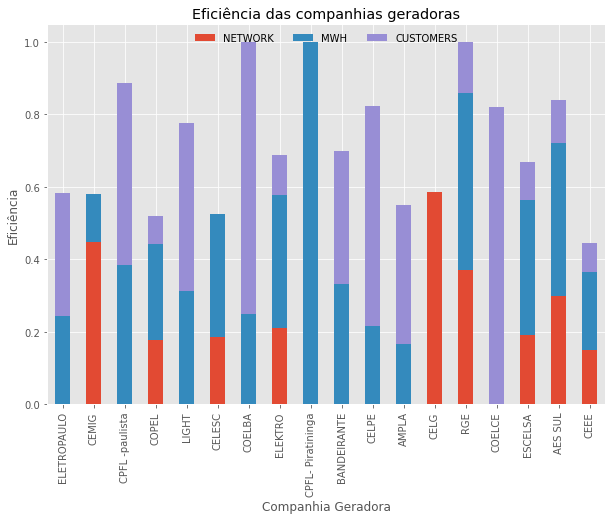

In [29]:
## Plottando os valores
dfVirtual.plot(kind='bar', stacked=True, figsize=(10, 7))

## Determinando nome dos eixos
plt.xlabel("Companhia Geradora")
plt.ylabel("Eficiência")
plt.title("Eficiência das companhias geradoras")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None, ncol=3, loc='upper center')

##### Outras análises

In [30]:
## Pegando os lambdas (resoluções do problema dual) e criando um dataframe
dfLambda = pd.DataFrame(mLambda, index=df['UTILITY'], columns=df['UTILITY'])

In [31]:
## Pegando valores iguais a 1 (unidades eficientes)
vUnidadesEficientes = np.where(vEficiencia > .999, True, False)
vUnidadesEficientes

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False, False,  True, False, False, False, False])

In [32]:
## Selecionando apenas esses indexes no dfLambda
dfLambdaEficiente = dfLambda.iloc[:, vUnidadesEficientes]
dfLambdaEficiente

UTILITY,COELBA,CPFL- Piratininga,RGE
UTILITY,,,
ELETROPAULO,5.744057e-01,2.437208,0.000000
CEMIG,9.781205e-01,0.000000,2.940364
CPFL -paulista,0.000000e+00,0.766624,0.000000
COPEL,7.506882e-02,0.258974,2.387362
LIGHT,3.952603e-01,1.325987,0.000000
CELESC,0.000000e+00,0.410153,1.597419
COELBA,1.000000e+00,0.000000,0.000000
ELEKTRO,0.000000e+00,0.000000,0.000000
CPFL- Piratininga,1.253783e-16,1.000000,0.000000


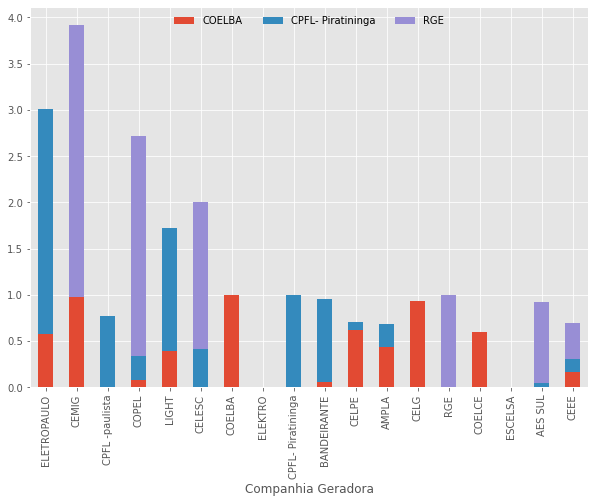

In [33]:
## Plottando os valores
dfLambdaEficiente.plot(kind='bar', stacked=True, figsize=(10, 7))

## Determinando nome dos eixos
plt.xlabel("Companhia Geradora")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None, ncol=3, loc='upper center')

### Análise VRS - Variable Returns to Scale / Retornos Variáveis de Escala


#### Dados

In [34]:
## Criando uma nova matriz com os coeficientes tecnológicos
# Vetor de 1
dfTecno["1"] = 1
dfTecno["-1"] = -1

# Convertendo pra numpy
mTecno = dfTecno

# Vendo saída
dfTecno

,OPEX,NETWORK,MWH,CUSTOMERS,1,-1
0,-1249143613,45213,39922710,5987783,1,-1
1,-1682334644,460219,37476802,6832546,1,-1
2,-497290782,89879,25267579,3502793,1,-1
3,-1018866491,224817,23525040,3628209,1,-1
4,-557206112,58074,22902552,3640182,1,-1
5,-721455274,144896,18105811,2237127,1,-1
6,-436436014,215001,14286757,4622046,1,-1
7,-414602018,107116,13398558,2123670,1,-1
8,-195789961,22236,13013378,1367488,1,-1
9,-286832273,27496,12536237,1482518,1,-1


#### Otimização passo a passo para a 1ª linha

In [35]:
## Encontrando coeficientes da função objetivo
obj = np.hstack((
    [0] * s,
    dfOutput.values[0, :],
    1, 
    -1 
))

## O problema de DEA é de maximização, mas o scipy só aceita minimização. Para isso:
obj = -obj
# Vendo array
obj

array([        0,    -45213, -39922710,  -5987783,        -1,         1])

In [36]:
## Encontrando restrições (constraints)
# Juntando a última linha (1º valor de dfInput seguido de zeros)
vUltLinhaCon = np.hstack((
    dfInput.values[0], 
    [0] * (m + 2)
))

# Matriz de constraints
con = np.vstack((
    mTecno,
    vUltLinhaCon
))

# Vendo tamanho
con.shape

(19, 6)

In [37]:
## Pegando os coeficientes de desigualdade e igualdade
lhs_ineq = con[:-1]
lhs_eq = con[-1]

In [38]:
# Otimizando
opt = linprog(
    c=obj,  # função objetivo (vetor de tamanho 6)
    A_ub=lhs_ineq,  # coeficientes das restrições de desigualdade (matriz de tamanho N(18) x 6)
    b_ub=rhs_ineq,  # valor das restrições de desigualdade (vetor de tamanho N (18))
    A_eq=lhs_eq.reshape((1, 6)),  # coeficientes das restrições de igualdade (matriz de tamanho 1 x 6)
    b_eq=rhs_eq, # valor das restrições de igualdade (vetor de tamanho 1 -> número)
    method='revised simplex'
)
# Vendo resultado
opt

     con: array([0.])
     fun: -1.0
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([0.        , 0.27729357, 0.        , 0.43232083, 0.07244697,
       0.48051254, 0.        , 0.3357973 , 0.26967005, 0.33571152,
       0.22892086, 0.39150387, 0.61911309, 0.37252018, 0.27266755,
       0.42382637, 0.40539057, 0.51674035])
  status: 0
 success: True
       x: array([8.00548463e-10, 0.00000000e+00, 1.81902842e-08, 1.34935606e-07,
       0.00000000e+00, 5.34170566e-01])

In [39]:
## Pegando multiplicadores
vMultiplicadores = opt.x

## Pegando índices de eficiência (- porque fizemos -obj antes)
nEficiencia = -opt.fun

#### Loop e Gráfico de Eficiência de Escala

In [40]:
## Fazendo o loop sobre todos as outras linhas do DataFrame
# Criando variáveis para guardar os vetores da otimização
mPesosVRS = vMultiplicadores
vEficienciaVRS = nEficiencia

for nLinha in range(1, N):
  ## Encontrando coeficientes da função objetivo;
  # Como o scipy só aceita minimização, pegamos o negativo do valor
  obj = -np.hstack(([0] * s, dfOutput.values[nLinha, :], 1, -1))

  ## Encontrando restrições (constraints)
  # Juntando a última linha (1º valor de dfInput seguido de zeros)
  vUltLinhaCon = np.hstack((dfInput.values[nLinha], [0] * (m + 2)))

  # Matriz de constraints
  con = np.vstack((mTecno, vUltLinhaCon))

  ## Pegando os coeficientes de desigualdade e igualdade
  lhs_ineq = con[:-1]
  lhs_eq = con[-1]

  ### Problema Primal
  opt = linprog(
    c=obj,  # função objetivo (vetor de tamanho 6)
    A_ub=lhs_ineq,  # coeficientes das restrições de desigualdade (matriz de tamanho N(18) x 6)
    b_ub=rhs_ineq,  # valor das restrições de desigualdade (vetor de tamanho N (18))
    A_eq=lhs_eq.reshape((1, 6)),  # coeficientes das restrições de igualdade (matriz de tamanho 1 x 6)
    b_eq=rhs_eq, # valor das restrições de igualdade (vetor de tamanho 1 -> número)
    method='revised simplex'
  )

  ## Pegando multiplicadores
  mPesosVRS = np.vstack((mPesosVRS, opt.x))

  ## Pegando índices de eficiência (- porque fizemos -obj antes)
  vEficienciaVRS = np.hstack((vEficienciaVRS, -opt.fun))

In [41]:
## Calculando eficiência de escala
vEficienciaEscala = vEficiencia / vEficienciaVRS

In [42]:
## Criando DataFrame com todos os vetores de eficiência
# Colocando os vetores no formato correto
mEficiencia = np.vstack((vEficiencia, vEficienciaVRS, vEficienciaEscala)).T

dfEficiencia = pd.DataFrame(mEficiencia, index=df["UTILITY"], columns=["CRS", "VRS", "Escala"])
dfEficiencia

,CRS,VRS,Escala
UTILITY,,,
ELETROPAULO,0.582697,1.000000,0.582697
CEMIG,0.579460,1.000000,0.579460
CPFL -paulista,0.885425,1.000000,0.885425
COPEL,0.518586,0.726337,0.713974
LIGHT,0.775513,0.856108,0.905859
CELESC,0.523934,0.592742,0.883915
COELBA,1.000000,1.000000,1.000000
ELEKTRO,0.687900,0.720977,0.954122
CPFL- Piratininga,1.000000,1.000000,1.000000


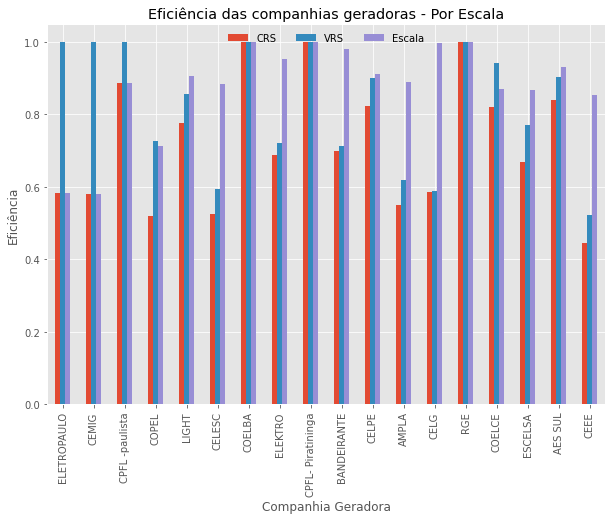

In [43]:
## Plottando os valores
dfEficiencia.plot(kind='bar', stacked=False, figsize=(10, 7))

## Determinando nome dos eixos
plt.xlabel("Companhia Geradora")
plt.ylabel("Eficiência")
plt.title("Eficiência das companhias geradoras - Por Escala")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None, ncol=3, loc='upper center')

# Obrigado!